In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Gets path of data for state
def get_path(statecode):
    return 'MCM' + str(statecode) + 'Data.csv'

# Create data dictionary, the path should be to a csv of the data dictionary from the competition
def create_data_dictionary(path):
    datadic = pd.read_csv(path, header=0, index_col=0)
    return datadic

# Graph a specific attribute of a list of states over time
def graph_attribute(attribute, statecodes):

    fig, ax = plt.subplots()

    # Get colors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(statecodes)))

    # Run through statecodes list
    for color, state in zip(colors, statecodes):

        statedata = pd.read_csv(get_path(state), index_col = 0, header=0)
        ax.plot(statedata.index, statedata.loc[:, attribute], color=color, label=state)

    ax.set(title = '{} Over Time'.format(attribute), ylabel = '{} Use'.format(attribute), xlabel='Year')
    ax.legend()
    plt.show()


# Graph multiple attributes of a single state, get correlation between them, presumably they have the same units
def graph_multiple_attributes(attributes, state):

    fig, ax = plt.subplots()

    # Get colors and state data
    colors = plt.cm.rainbow(np.linspace(0, 1, len(attributes)))
    statedata = pd.read_csv(get_path(state), index_col=0, header=0)

    # Run through attributes list
    for color, attribute in zip(colors, attributes):

        ax.plot(statedata.index, statedata.loc[:, attribute], color=color, label=attribute)

    ax.set(title = 'Attributes in {} Over Time'.format(state), ylabel = 'Use', xlabel='Year')
    ax.legend()
    plt.show()

# Run examples of graphing functions and create the data dictionary

datadic = create_data_dictionary('ProblemCDataDic.csv')


In [5]:
def get_pop(state):
    file_name = "MCM"+state+"Data.csv"
    df = pd.read_csv(file_name)
    return df['TPOPP']*1000

states=["NM","CA","AZ","TX"]
populations = [get_pop(state) for state in states]
populations_df = pd.concat(populations, axis=1)

populations_df.columns = states
populations_df.head()

,NM,CA,AZ,TX
0,954000.0,15870000.0,1321000.0,9624000.0
1,965000.0,16497000.0,1407000.0,9820000.0
2,979000.0,17072000.0,1471000.0,10053000.0
3,989000.0,17668000.0,1521000.0,10159000.0
4,1006000.0,18151000.0,1556000.0,10270000.0


In [13]:
#Energy Source Profile
def get_total_consumption(state,population, year):
    file_name = "MCM"+state+"Data.csv"
    df = pd.read_csv(file_name)
    df_year = df.iloc[year-2010,:]
    tc_btu_cols = [index for (index,value) in df_year.iteritems() if index.endswith('TCB')]
    tc_btu = df_year[tc_btu_cols]/population
    return tc_btu

def plot_important_sources(year, t):
    states=["NM","CA","AZ","TX"]
    populations = populations_df.iloc[year-2010,:]
    dfs = []
    for state, population in zip(states, populations):
        dfs.append(get_total_consumption(state, population, year))
    tc_df = pd.concat(dfs, axis=1)
    tc_df.columns = states
    important_sources = [i for i in range(0, len(tc_df)) if (tc_df.iloc[i,0]>=t or tc_df.iloc[i,1]>=t or tc_df.iloc[i,2]>=t or tc_df.iloc[i,3]>=t)]
    tc_df_important = tc_df.iloc[important_sources,:]
    plt.clf()
    tc_df_important.plot(kind='bar', title="Per-Capita Consumption by Source in "+str(year))
    plt.show()

In [14]:
#Sector Profile
def get_sector_consumption(state,population,year):
    file_name = "MCM"+state+"Data.csv"
    df = pd.read_csv(file_name)
    df_year = df.iloc[year-2010,:]
    residential = [index for (index,value) in df_year.iteritems() if index.endswith('RCB')]
    commercial = [index for (index,value) in df_year.iteritems() if index.endswith('CCB')]
    industrial = [index for (index,value) in df_year.iteritems() if index.endswith('ICB')]
    transportation = [index for (index,value) in df_year.iteritems() if index.endswith('ACB')]
    sector_btu = pd.DataFrame(columns=["Residential","Commercial","Industrial","Transportation"])

    residential_tot = np.sum(df_year[residential].values)
    commercial_tot = np.sum(df_year[commercial].values)
    industrial_tot = np.sum(df_year[industrial].values)
    transportation_tot = np.sum(df_year[transportation].values)
    #total_btu = residential_tot+commercial_tot+industrial_tot+transportation_tot
    
    sector_btu = {}
    sector_btu["Residential"] = residential_tot/population
    sector_btu["Commercial"] = commercial_tot/population
    sector_btu["Industrial"] = industrial_tot/population
    sector_btu["Transportation"] = transportation_tot/population
    return pd.Series(sector_btu)

def plot_sectors(year):
    states=["NM","CA","AZ","TX"]
    populations = populations_df.iloc[year-2010,:]
    dfs = []
    for state, population in zip(states, populations):
        dfs.append(get_sector_consumption(state, population, year))
    sc_df = pd.concat(dfs, axis=1)
    sc_df.columns = states
    plt.clf()
    sc_df.plot(kind='bar', title="Per-Capita Consumption by Sector in "+str(year))
    plt.show()

In [15]:
#Production Profile
def get_production(state,population,year):
    file_name = "MCM"+state+"Data.csv"
    df = pd.read_csv(file_name)
    df_year = df.iloc[year-2010,:]
    pr_btu_cols = [index for (index,value) in df_year.iteritems() if index.endswith('PRB') and not index == "TEPRB"]
    pr_btu = df_year[pr_btu_cols]/population
    return pr_btu

def plot_production(year):
    states=["NM","CA","AZ","TX"]
    populations = populations_df.iloc[year-2010,:]
    dfs = []
    for state, population in zip(states, populations):
        dfs.append(get_production(state, population, year))
    pr_df = pd.concat(dfs, axis=1)
    pr_df.columns = states
    plt.clf()
    pr_df.plot(kind='bar', title="Per-Capita Energy Production by Type in "+str(year))
    plt.show()

In [16]:
#Electricity Generation Profile
def get_energy_generation(state,population,year):
    file_name = "MCM"+state+"Data.csv"
    df = pd.read_csv(file_name)
    df_year = df.iloc[year-2010,:]
    eg_btu_cols = [index for (index,value) in df_year.iteritems() if index.endswith('EGB')]
    eg_btu = df_year[eg_btu_cols]/population
    return eg_btu

def plot_energy_generation(year):
    states=["NM","CA","AZ","TX"]
    populations = populations_df.iloc[year-2010,:]
    dfs = []
    for state, population in zip(states, populations):
        dfs.append(get_energy_generation(state, population, year))
    eg_df = pd.concat(dfs, axis=1)
    eg_df.columns = states
    plt.clf()
    eg_df.plot(kind='bar', title="Per-Capita Energy Generation by Type in "+str(year))
    plt.show()

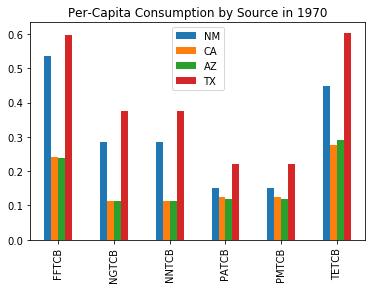

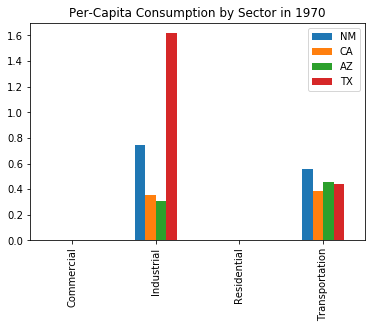

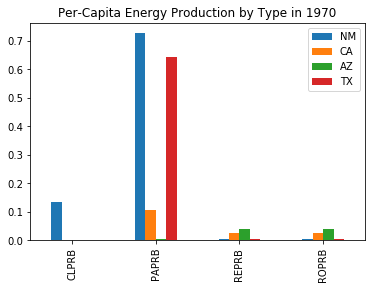

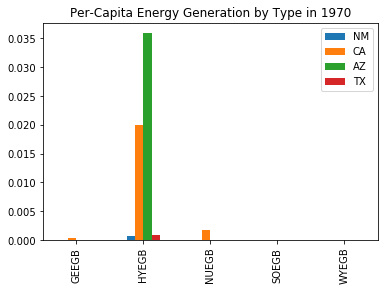

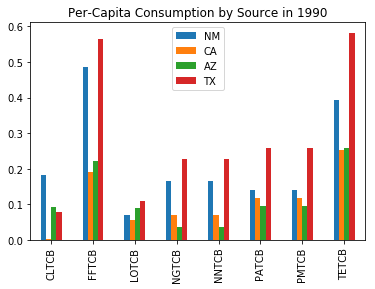

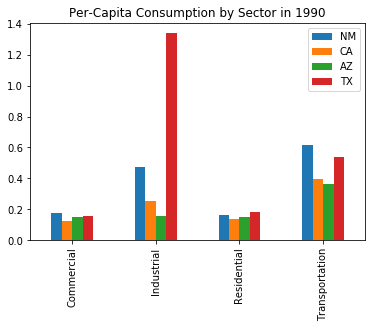

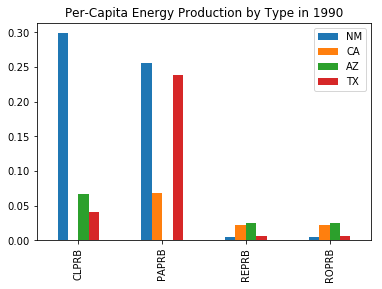

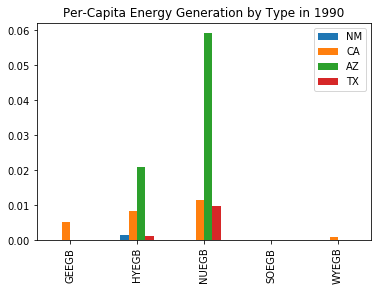

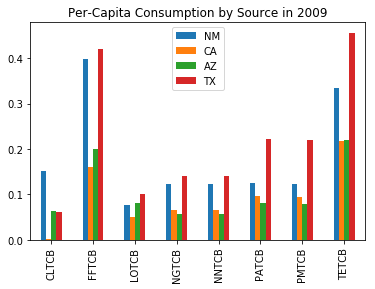

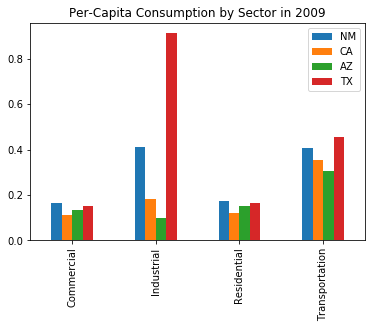

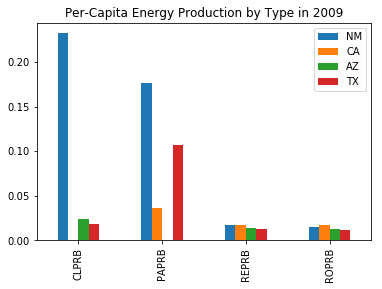

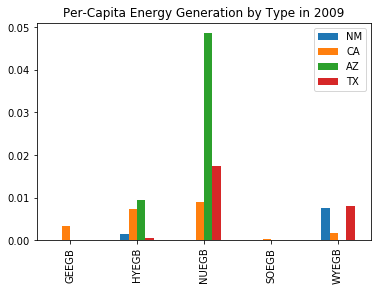

In [17]:
import matplotlib.pyplot as plt
years = [1970,1990,2009]
for year in years:
    plot_important_sources(year, .1)
    plot_sectors(year)
    plot_production(year)
    plot_energy_generation(year)

In [ ]:
graph_attribute('BMTCB', ['AZ', 'CA', 'NM', 'TX'])
attributes = [index for index in datadic.index if 'TCV' in index]
graph_multiple_attributes(attributes, 'NM')